# Finanzas Computacionales
## Proyecto individual
### Profesor: Dr. Luis Vicente Montiel Cendejas
### Estudiante: Eduardo Selim Martínez Mayorga
### ID: 405017834
### Fecha de entrega: 10 de Mayo de 2022

# Implementación

In [1]:
import numpy as np
import pandas as pd # librería para manejo de dataframes
import matplotlib.pyplot as plt
import yfinance as yf # librería para descarga de históricos de Yahoo Finance
import math
import copy

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
ticker = 'AAPL'
fecha_inicio = '2021-01-01'
fecha_fin = '2022-03-31'

In [3]:
def calcula_media(ticker, fecha_inicio, fecha_fin):
    df_hist = yf.download(ticker,
                          start = fecha_inicio,
                          end = fecha_fin,
                          progress=False)
    # Cálculo de rendimientos
    rendims = (df_hist.iloc[1:]['Close'] - df_hist.shift(1).iloc[1:]['Close'])/df_hist.shift(1).iloc[1:]['Close']
    # mu
    mu = np.mean(rendims) #media aritmética
    return(mu)

In [4]:
calcula_media(ticker, fecha_inicio, fecha_fin)

0.001152774861035118

In [5]:
def calcula_desv_est(ticker, fecha_inicio, fecha_fin):
    df_hist = yf.download(ticker,
                          start = fecha_inicio,
                          end = fecha_fin,
                          progress=False)
    # Cálculo de rendimientos
    rendims = (df_hist.iloc[1:]['Close'] - df_hist.shift(1).iloc[1:]['Close'])/df_hist.shift(1).iloc[1:]['Close']
    # sigma
    sigma = np.std(rendims) #desviación estándar muestral
    return(sigma)

In [6]:
calcula_desv_est(ticker, fecha_inicio, fecha_fin)

0.016430708142253208

In [7]:
def calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin):
    df_hist1 = yf.download(ticker1,
                          start = fecha_inicio,
                          end = fecha_fin,
                          progress=False)
    df_hist2 = yf.download(ticker2,
                          start = fecha_inicio,
                          end = fecha_fin,
                          progress=False)
    # Cálculo de rendimientos
    rendims1 = (df_hist1.iloc[1:]['Close'] - df_hist1.shift(1).iloc[1:]['Close'])/df_hist1.shift(1).iloc[1:]['Close']
    rendims2 = (df_hist2.iloc[1:]['Close'] - df_hist2.shift(1).iloc[1:]['Close'])/df_hist2.shift(1).iloc[1:]['Close']
    # Correlación: rho
    rho = np.corrcoef(rendims1, rendims2) #correlación muestral
    return(rho[0, 1])

In [38]:
ticker1 = 'AAPL'
ticker2 = 'SBUX'
fecha_inicio = '2021-01-01'
fecha_fin = '2022-03-31'

In [39]:
calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin)

0.46221998740261633

In [10]:
def ultimo_precio(ticker, fecha_inicio, fecha_fin): #Para decidir cuál será el precio inicial de la simulación
    df_hist = yf.download(ticker,
                          start = fecha_inicio,
                          end = fecha_fin,
                          progress=False)
    S0 = df_hist.iloc[df_hist.shape[0]-1]['Close']
    return(S0)

In [11]:
ultimo_precio(ticker, fecha_inicio, fecha_fin)

177.77000427246094

## Valuación opciones calls y put Americanas vía árbol binomial sobre un activo

$$u = \exp\{rh + \sigma_P\sqrt{h}\}$$
$$d = \exp\{rh - \sigma_P\sqrt{h}\}$$
$$p^* = (1+e^{\sigma_P\sqrt{h}})^{-1}$$

In [12]:
def arbol_americano(ticker, fecha_inicio, fecha_fin, K, T,r,N,tipo = "put"):
    # obtención de sigma, u y d
    sigma = calcula_desv_est(ticker, fecha_inicio, fecha_fin)
    dt = T/N
    u = np.exp(r*dt + sigma*np.sqrt(dt))
    d = np.exp(r*dt - sigma*np.sqrt(dt))
    p = (np.exp(r*dt)-d)/(u-d)
    fact_desc = np.exp(-r*dt)
    
    # Nodo inicial
    S0 = ultimo_precio(ticker, fecha_inicio, fecha_fin)
    
    # Se obtiene último nodo del árbol
    S = np.zeros(N+1)
    for j in range(0,N+1):
        S[j] = S0 * (u**j) * d**(N-j)
        
    # Se calcula el payoff de la opción
    V = np.zeros(N+1)
    for j in range(0,N+1):
        if tipo == "call":
            V[j] = max(0, S[j]-K)
        else:
            V[j] = max(0, K-S[j])
            
    # Arbol hacia atrás
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * (u**j) * d**(i-j)
            V[j] = fact_desc * (p*V[j+1] + (1-p)*V[j])
            if tipo == "call":
                V[j] = max(V[j], S-K)
            else:
                V[j] = max(V[j], K-S)
    return V[0]

In [13]:
K = 170
T = 1 # Plazo del contrato en años
r = 0.06 # tasa de interés libre de riesgo anual
N = 12 #longitud del árbol

In [14]:
arbol_americano(ticker1, fecha_inicio, fecha_fin, K, T,r,N,tipo = "call")

17.67003356313844

## Valuación opciones calls y put Americanas vía árbol binomial sobre un portafolio de activos correlacionados

$\sigma_P^2 \equiv Var(P) = w^2Var(S_1) + (1-w)^2Var(S_2) + 2w(1-w)\rho\sigma_1\sigma_2$

In [15]:
def arbol_americano_portafolio(ticker1,
                               ticker2,
                               w, #Proporción del activo 1
                               fecha_inicio, fecha_fin, K, T,r,N,tipo = "call"):
    #Obtención de sigma_P
    desv1 = calcula_desv_est(ticker1, fecha_inicio, fecha_fin)
    varianza1 = desv1**2
    desv2 = calcula_desv_est(ticker2, fecha_inicio, fecha_fin)
    varianza2 = desv2**2
    correl = calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin)
    
    # obtención de sigma, u y d
    sigma = np.sqrt((w**2)*varianza1 + ((1-w)**2)*varianza2 + 2*w*(1-w)*correl)
    dt = T/N
    u = np.exp(r*dt + sigma*np.sqrt(dt))
    d = np.exp(r*dt - sigma*np.sqrt(dt))
    p = (np.exp(r*dt)-d)/(u-d)
    fact_desc = np.exp(-r*dt)
    
    # Nodo inicial
    S0_1 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
    S0_2 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
    S0 = w*S0_1 + (1-w)*S0_2
    
    # Se obtiene último nodo del árbol
    S = np.zeros(N+1)
    for j in range(0,N+1):
        S[j] = S0 * (u**j) * d**(N-j)
        
    # Se calcula el payoff de la opción
    V = np.zeros(N+1)
    for j in range(0,N+1):
        if tipo == "call":
            V[j] = max(0, S[j]-K)
        else:
            V[j] = max(0, K-S[j])
            
    # Arbol hacia atrás
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * (u**j) * d**(i-j)
            V[j] = fact_desc * (p*V[j+1] + (1-p)*V[j])
            if tipo == "call":
                V[j] = max(V[j], S-K)
            else:
                V[j] = max(V[j], K-S)
    return V[0]

In [16]:
# Para que definir un precio strike que tenga sentido
K1 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
K2 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
K = (K1+K2)/2

w = 0.7

In [17]:
arbol_americano_portafolio(ticker1, ticker2,
                               w, #Proporción del activo 1
                               fecha_inicio, fecha_fin, K, T,r,N,tipo = "call")

79.48092737001977

## Valuación opciones calls y put Americanas vía Longstaff y Schwarz

In [18]:
def payoff_call(x):
    return(max(x-K,0))

def payoff_put(x):
    return(max(K-x,0))

def vp_un(x):
    return(x*math.exp((-1)*r))

In [19]:
## Para generar simulaciones un activo
def genera_simulaciones_individual(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T):
    #Obtención de parámetros
    media1 = calcula_media(ticker1, fecha_inicio, fecha_fin)
    desv1 = calcula_desv_est(ticker1, fecha_inicio, fecha_fin)
    
    
    N = T / dt
    t = np.arange(1, int(N) + 1)
    
    # Precio inicial de la simulación
    S_01 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
    
    # Pasos aleatorios primer activo
    b = {str(sim): np.random.normal(0, 1, int(N)) for sim in range(1, num_sims + 1)}
    
    W = {str(sim): b[str(sim)].cumsum() for sim in range(1, num_sims + 1)}
    drift = (media1 - 0.5 * desv1**2) * t
    proc_varianza = {str(sim): desv1 * W[str(sim)] for sim in range(1, num_sims + 1)}
    S1 = np.array([S_01 * np.exp(drift + proc_varianza[str(sim)]) for sim in range(1, num_sims + 1)]) 
    S1 = np.hstack((np.array([[S_01] for sim in range(num_sims)]), S1))
    
    return(S1)

In [20]:
num_sims = 10
dt = 1
T = 252/2

genera_simulaciones_individual(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T)

array([[177.77000427, 181.59833007, 183.39467422, ..., 169.70752386,
        171.3217765 , 171.61802853],
       [177.77000427, 177.79256264, 181.7324462 , ..., 168.00034832,
        171.77217357, 172.70531606],
       [177.77000427, 178.14447386, 181.20333138, ..., 240.84332019,
        248.60880976, 243.92212747],
       ...,
       [177.77000427, 179.13988232, 179.63384562, ..., 227.2182034 ,
        230.46901388, 232.93282384],
       [177.77000427, 182.39525025, 183.61507009, ..., 215.81457158,
        222.95912303, 225.966479  ],
       [177.77000427, 179.0465566 , 177.13262752, ..., 253.55847204,
        258.10683451, 252.60189475]])

In [21]:
def genera_df_simulaciones(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T):
    trayectorias = genera_simulaciones_individual(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T)
    df_pr = pd.DataFrame(trayectorias)
    df_pr = df_pr.drop([0], axis = 1, inplace = False)
    
    nombres_columnas = list(range(1,len(trayectorias[0])))
    nombres_columnas = [str(x) for x in nombres_columnas]
    df_pr.columns = nombres_columnas
    
    df = df_pr
    return(df)

In [22]:
num_sims = 10
dt = 1
T = 252/2

genera_df_simulaciones(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T)

,1,2,3,4,5,6,7,8,9,10,...,117,118,119,120,121,122,123,124,125,126
0,182.841183,184.280612,181.529738,184.061993,182.450138,175.774364,176.991026,176.980348,178.027041,183.452537,...,244.229039,239.659151,240.097384,233.499557,237.059123,239.040358,238.132189,237.772891,235.726346,231.401780
1,177.667885,180.401005,175.705210,175.626979,173.538575,171.103750,168.111878,164.857103,168.588959,168.477014,...,176.657827,175.336602,175.704479,176.084656,178.204022,180.566224,185.212076,187.177315,191.664197,189.264692
2,175.963277,174.513337,174.806917,177.633699,181.832491,180.379094,179.887703,174.610297,177.396905,175.344717,...,196.636916,195.949818,203.579538,199.259506,200.769954,201.759494,199.321822,197.525585,196.977347,190.327358
3,176.271549,177.723969,177.485813,181.502757,180.915808,178.760161,178.075220,180.077926,183.906325,184.541793,...,218.258123,222.320999,222.678273,224.428372,219.710766,221.083984,217.345004,221.846860,210.876165,205.309658
4,178.496104,181.730025,181.804786,184.241938,179.566388,176.607686,179.835292,181.085542,183.390028,181.831038,...,214.841499,214.931446,217.490949,214.230134,222.351787,218.948290,222.182078,220.729316,226.010896,229.546548
5,180.615384,179.070164,177.166014,177.446602,173.427307,174.284824,175.423097,178.655823,178.449773,177.338779,...,208.616559,214.659180,220.130423,221.817836,218.242818,219.143476,221.247318,223.097985,231.900500,231.729998
6,176.288221,178.845833,177.187441,177.392583,180.736799,180.802938,181.855978,185.316820,185.724191,187.071071,...,283.928863,292.736836,290.103249,283.586028,285.095773,286.382720,291.093810,286.414860,287.026163,284.218002
7,177.798793,175.117849,170.423138,173.241282,171.789600,170.073571,170.223321,169.314873,172.595798,171.015576,...,185.120968,187.969997,190.135965,190.334169,188.200929,190.647287,190.691645,190.897209,194.352413,196.518877
8,178.702435,175.641268,177.063737,177.328119,182.341276,180.010938,178.100544,178.524607,180.600886,179.070408,...,159.444308,159.702187,163.592755,163.107827,161.932980,160.493220,163.828718,164.407697,165.620957,161.114974
9,177.071183,178.005294,181.219568,183.062688,185.920479,182.268171,183.644500,185.090921,184.120032,184.177921,...,170.446466,169.319979,168.849878,167.565415,170.435694,172.824516,169.424913,171.620563,173.523606,173.089363


In [23]:
def ejercicio_americana_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado):
    df = genera_df_simulaciones(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T)
    num_cols = df.shape[1]
    num_rengls = df.shape[0]
    
    # Primera ejecucion (en el penúltimo nodo)
    payoff = df.iloc[:,(num_cols -1)].apply(funcion_payoff)
    indices_ejercicio = list(payoff[payoff>0].index)
    posicion = str(num_cols -1)
    payoff_lag = df[posicion].apply(funcion_payoff)
    indices_ejercer_lag = list(payoff_lag[payoff_lag>0].index)
    x = df.iloc[indices_ejercer_lag,:][posicion]
    y = payoff[indices_ejercer_lag].apply(vp_un)
    df_ml = pd.concat([y,x],axis=1)
    df_ml.columns = ['y', 'x']
    X = df_ml['x'].values.reshape(-1, 1)
    y = df_ml['y'].values.reshape(-1, 1)
    polin = PolynomialFeatures(degree = grados_pasado, include_bias=True)
    X_polin = polin.fit_transform(X)
    polin.fit(X_polin, y)
    reg_pol = LinearRegression()
    reg_pol.fit(X_polin, y)
    y_predicted =reg_pol.predict(X_polin)
    y_pred_lista = [ item for elem in y_predicted for item in elem]
    y_pred_serie = pd.Series(y_pred_lista)
    y_pred_serie.index = payoff_lag[payoff_lag>0].index
    df_comparacion = pd.concat([payoff_lag[payoff_lag>0],y_pred_serie],axis=1)
    df_comparacion.columns = ['intrinseco', 'continuacion']
    df_comparacion['ejercer'] = np.where(df_comparacion['intrinseco'] >= df_comparacion['continuacion'],True,False)
    lista_ejercer = list(df_comparacion[df_comparacion['ejercer'] == True].index)
    
    lst = []
    lst.append(indices_ejercicio)
    lst.append(lista_ejercer)
    
    # Segunda ejecucion
    for m in range(2,num_cols):
        payoff = df.iloc[:,(num_cols - m)].apply(funcion_payoff)
        lista_payoff = list(payoff.index)
        lista_anulados = list(set(lista_payoff) - set(lista_ejercer)) + list(set(lista_ejercer) - set(lista_payoff))
        payoff[lista_anulados] = 0
        posicion = str(num_cols - m)
        payoff_lag = df[posicion].apply(funcion_payoff)
        indices_ejercer_lag = list(payoff_lag[payoff_lag>0].index)
        x = df.iloc[indices_ejercer_lag,:][posicion]
        y = payoff[indices_ejercer_lag].apply(vp_un)
        df_ml = pd.concat([y,x],axis=1)
        df_ml.columns = ['y', 'x']
        X = df_ml['x'].values.reshape(-1, 1)
        y = df_ml['y'].values.reshape(-1, 1)
        polin = PolynomialFeatures(degree = 2, include_bias=True) # Grados de la regresión
        X_polin = polin.fit_transform(X)
        polin.fit(X_polin, y)
        reg_pol = LinearRegression()
        reg_pol.fit(X_polin, y)
        y_predicted =reg_pol.predict(X_polin)
        y_pred_lista = [item for elem in y_predicted for item in elem]
        y_pred_serie = pd.Series(y_pred_lista)
        y_pred_serie.index = payoff_lag[payoff_lag>0].index
        df_comparacion = pd.concat([payoff_lag[payoff_lag>0],y_pred_serie],axis=1)
        df_comparacion.columns = ['intrinseco', 'continuacion']
        df_comparacion['ejercer'] = np.where(df_comparacion['intrinseco'] >= df_comparacion['continuacion'],True,False)
        lista_ejercer = list(df_comparacion[df_comparacion['ejercer'] == True].index)
        lst.append(lista_ejercer)
    return([lst,df])

In [24]:
num_sims = 1000
dt = 1
T = 252/2
funcion_payoff = payoff_put
K = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
grados_pasado = 2

ejercicio_americana_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]

[[0,
  11,
  13,
  15,
  19,
  20,
  22,
  28,
  33,
  38,
  40,
  41,
  43,
  51,
  52,
  56,
  61,
  62,
  64,
  66,
  67,
  68,
  73,
  75,
  77,
  109,
  117,
  118,
  119,
  121,
  130,
  131,
  136,
  137,
  144,
  155,
  161,
  170,
  171,
  174,
  178,
  182,
  206,
  207,
  208,
  214,
  217,
  220,
  223,
  232,
  236,
  242,
  243,
  244,
  247,
  249,
  251,
  254,
  258,
  266,
  272,
  276,
  280,
  297,
  300,
  306,
  307,
  313,
  315,
  317,
  319,
  322,
  327,
  329,
  338,
  348,
  361,
  363,
  371,
  373,
  374,
  377,
  378,
  383,
  385,
  390,
  392,
  393,
  396,
  397,
  409,
  413,
  431,
  436,
  438,
  440,
  442,
  447,
  451,
  453,
  454,
  456,
  458,
  459,
  464,
  466,
  470,
  478,
  481,
  482,
  497,
  504,
  510,
  512,
  514,
  526,
  527,
  530,
  538,
  552,
  554,
  564,
  565,
  573,
  576,
  577,
  581,
  590,
  591,
  594,
  599,
  600,
  611,
  616,
  617,
  622,
  637,
  640,
  643,
  647,
  649,
  656,
  668,
  678,
  681,
  682,
  68

In [25]:
def obtiene_estrategia_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado):
    lst = ejercicio_americana_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]
    df = ejercicio_americana_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[1]

    num_cols = df.shape[1]
    lst.reverse()
    num_rengls = num_sims
    primer_colum = pd.Series([0 for i in range(0, num_rengls)])
    primer_colum[lst[0]] = 1
    df_estrategia = primer_colum.to_frame()
    for j in range(1,num_cols):
        colum = pd.Series([0 for i in range(0, num_rengls)])
        colum[lst[j]] = 1
        df_estrategia = pd.concat([df_estrategia,colum],axis=1)
    lista_fechas_ejercicio = list(0 for i in range(0, num_rengls))
    for i in range(num_rengls):
        a = df_estrategia.iloc[i,:].tolist()
        if sum(a) == 0:
            lista_fechas_ejercicio[i] = -1
        else:
            lista_fechas_ejercicio[i]= a.index(max(a))
    return([lista_fechas_ejercicio,df])

In [26]:
num_sims = 1000
dt = 1
T = 252/2
funcion_payoff = payoff_put
K = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
grados_pasado = 2

lista_fechas_ejercicio = obtiene_estrategia_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]

In [27]:
def calcula_precio_americana(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado):
    lista_fechas_ejercicio = obtiene_estrategia_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]
    df = obtiene_estrategia_LS(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[1]
    
    # Para la valuación:
    num_rengls = num_sims
    payoff_ejercicio = list(0 for i in range(0, num_rengls))
    for i in range(num_rengls):
        if lista_fechas_ejercicio[i]<0:
            payoff_ejercicio[i] = 0
        else:
            payoff_ejercicio[i] = funcion_payoff(df.iloc[i,lista_fechas_ejercicio[i]])*math.exp((-r)*(lista_fechas_ejercicio[i]+1))
    
    # Para el histograma de las fechas de ejercicio
    estrategia_ejercicio = copy.copy(lista_fechas_ejercicio)

    for i in range(0,len(estrategia_ejercicio)):
        if estrategia_ejercicio[i]<0:
            estrategia_ejercicio[i] = np.nan
    
    return([np.mean(payoff_ejercicio),estrategia_ejercicio])

In [28]:
num_sims = 10000
dt = 1
T = 252/2
funcion_payoff = payoff_put
K = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
grados_pasado = 2

precio = calcula_precio_americana(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]
ejercicios_result = calcula_precio_americana(ticker1, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[1]

In [29]:
precio

1.0242225780562848

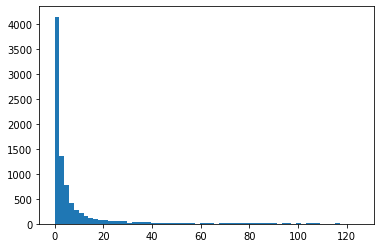

In [30]:
plt.hist(ejercicios_result, bins=int(T/2));

## Valuación opciones calls y put Americanas sobre un portafolio de dos acciones vía Longstaff y Schwarz

Si se quiere un derivado sobre un portafolio de dos acciones de la forma

$$P = wS^{[1]} + (1-w)S^{[2]}$$

Se supondrá una dinámica estocástica para cada uno de los activos

$$dS_t^{[1]} = rS_t^{[1]}dt + \sigma_1S_t^{[1]}dZ_t^{[1]}$$
$$dS_t^{[2]} = rS_t^{[2]}dt + \sigma_2S_t^{[2]}dZ_t^{[2]}$$

con $dZ_t^{[1]}dZ_t^{[1]} = \rho dt$, donde $\rho$ es la correlación entre los activos.\\

Es decir,

$$S_h^{[1]} = S_0^{[1]}\exp\left\{(\mu_1 - \frac{1}{2}\sigma_1^2)h + \sigma_1\sqrt{h}\epsilon_1\right\} $$
$$S_h^{[2]} = S_0^{[2]}\exp\left\{(\mu_2 - \frac{1}{2}\sigma_2^2)h + \sigma_2\sqrt{h}\epsilon_2\right\} $$

donde $\epsilon_1 = Z_1$ y $\epsilon_2 =\rho Z_1 + \sqrt{1-\rho^2}Z_2$.\\

Entonces, para simular trayectorias correlacioadas, lo único que cambia es la construcción de las variables Gaussianas $\epsilon_1,\epsilon_2$.\\

Por lo tanto, el portafolio $P = wS^{[1]} + (1-w)S^{[2]}$ se considera como cualquier otros activo, del que podemos obtener trayectorias simuladas y por lo tanto implementar valuación por simulación Monte-Carlo, en particular la que protagoniza este proyecto: la Longstaff \& Schwartz.\\

En este caso, también se satisface que el rendimiento del portafolio es

$$r_P = wr^{[1]} + (1-w)r^{[2]},$$

donde $r^{[1]},r^{[2]}$ son los rendimientos de los activos 1 y 2, respectivamente.\\

Con propiedades elementales de media y varianza se tiene que

$$\mathbb{E}(r_P) = w\mathbb{E}(r^{[1]}) + (1-w)\mathbb{E}(r^{[2]}),$$

$$Var(r_P) = w^2Var(r^{[1]}) + (1-w)^2Var(r^{[2]})+2w(1-w)\rho\sigma_1\sigma_2.$$

In [31]:
## Para generar simulaciones correlacionadas
def genera_simulaciones_correlacionadas(ticker1,ticker2,
                                        fecha_inicio, fecha_fin,
                                        num_sims, dt, T):
    #Obtención de parámetros
    media1 = calcula_media(ticker1, fecha_inicio, fecha_fin)
    media2 = calcula_media(ticker2, fecha_inicio, fecha_fin)
    desv1 = calcula_desv_est(ticker1, fecha_inicio, fecha_fin)
    varianza1 = desv1**2
    desv2 = calcula_desv_est(ticker2, fecha_inicio, fecha_fin)
    varianza2 = desv2**2
    correl = calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin)
    
    N = T / dt
    t = np.arange(1, int(N) + 1)
    
    # Precio inicial de la simulación
    S_01 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
    S_02 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
    
    # Pasos aleatorios primer activo
    b = {str(sim): np.random.normal(0, 1, int(N)) for sim in range(1, num_sims + 1)}
    # Pasos aleatorios segundo activo
    b2 = {str(sim): correl*b[str(sim)] + np.sqrt(1-correl**2)*np.random.normal(0, 1, int(N)) for sim in range(1, num_sims + 1)}
    
    W = {str(sim): b[str(sim)].cumsum() for sim in range(1, num_sims + 1)}
    drift = (media1 - 0.5 * desv1**2) * t
    proc_varianza = {str(sim): desv1 * W[str(sim)] for sim in range(1, num_sims + 1)}
    S1 = np.array([S_01 * np.exp(drift + proc_varianza[str(sim)]) for sim in range(1, num_sims + 1)]) 
    S1 = np.hstack((np.array([[S_01] for sim in range(num_sims)]), S1))
    
    W2 = {str(sim): b2[str(sim)].cumsum() for sim in range(1, num_sims + 1)}
    drift2 = (media2 - 0.5 * desv2**2) * t
    proc_varianza2 = {str(sim): desv2 * W2[str(sim)] for sim in range(1, num_sims + 1)}
    S2 = np.array([S_02 * np.exp(drift2 + proc_varianza2[str(sim)]) for sim in range(1, num_sims + 1)]) 
    S2 = np.hstack((np.array([[S_02] for sim in range(num_sims)]), S2))
    
    return([S1,S2])

In [32]:
def genera_df_portafolio(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T):
    precios_simulados = genera_simulaciones_correlacionadas(ticker1, ticker2,
                                                            fecha_inicio, fecha_fin, num_sims, dt, T)
    df1_pr = pd.DataFrame(precios_simulados[0])
    df1_pr = df1_pr.drop([0], axis = 1, inplace = False)
    df2_pr = pd.DataFrame(precios_simulados[1])
    df2_pr = df2_pr.drop([0], axis = 1, inplace = False)
    
    nombres_columnas = list(range(1,len(precios_simulados[0][0])))
    nombres_columnas = [str(x) for x in nombres_columnas]

    df1_pr.columns = nombres_columnas
    df2_pr.columns = nombres_columnas
    
    df = pd.DataFrame(columns=df1_pr.columns)
    for i in range(0,df1_pr.shape[0]):
        renglon = w*df1_pr.iloc[[i]] + (1-w)*df2_pr.iloc[[i]]
        df = pd.concat([df, renglon], ignore_index=True)
    return(df)

In [33]:
def ejercicio_americana_LS_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado):
    df = genera_df_portafolio(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T)
    num_cols = df.shape[1]
    num_rengls = df.shape[0]
    
    # Primera ejecucion (en el penúltimo nodo)
    payoff = df.iloc[:,(num_cols -1)].apply(funcion_payoff)
    indices_ejercicio = list(payoff[payoff>0].index)
    posicion = str(num_cols -1)
    payoff_lag = df[posicion].apply(funcion_payoff)
    indices_ejercer_lag = list(payoff_lag[payoff_lag>0].index)
    x = df.iloc[indices_ejercer_lag,:][posicion]
    y = payoff[indices_ejercer_lag].apply(vp_un)
    df_ml = pd.concat([y,x],axis=1)
    df_ml.columns = ['y', 'x']
    X = df_ml['x'].values.reshape(-1, 1)
    y = df_ml['y'].values.reshape(-1, 1)
    polin = PolynomialFeatures(degree = grados_pasado, include_bias=True)
    X_polin = polin.fit_transform(X)
    polin.fit(X_polin, y)
    reg_pol = LinearRegression()
    reg_pol.fit(X_polin, y)
    y_predicted =reg_pol.predict(X_polin)
    y_pred_lista = [ item for elem in y_predicted for item in elem]
    y_pred_serie = pd.Series(y_pred_lista)
    y_pred_serie.index = payoff_lag[payoff_lag>0].index
    df_comparacion = pd.concat([payoff_lag[payoff_lag>0],y_pred_serie],axis=1)
    df_comparacion.columns = ['intrinseco', 'continuacion']
    df_comparacion['ejercer'] = np.where(df_comparacion['intrinseco'] >= df_comparacion['continuacion'],True,False)
    lista_ejercer = list(df_comparacion[df_comparacion['ejercer'] == True].index)
    
    lst = []
    lst.append(indices_ejercicio)
    lst.append(lista_ejercer)
    
    # Segunda ejecucion
    for m in range(2,num_cols):
        payoff = df.iloc[:,(num_cols - m)].apply(funcion_payoff)
        lista_payoff = list(payoff.index)
        lista_anulados = list(set(lista_payoff) - set(lista_ejercer)) + list(set(lista_ejercer) - set(lista_payoff))
        payoff[lista_anulados] = 0
        posicion = str(num_cols - m)
        payoff_lag = df[posicion].apply(funcion_payoff)
        indices_ejercer_lag = list(payoff_lag[payoff_lag>0].index)
        x = df.iloc[indices_ejercer_lag,:][posicion]
        y = payoff[indices_ejercer_lag].apply(vp_un)
        df_ml = pd.concat([y,x],axis=1)
        df_ml.columns = ['y', 'x']
        X = df_ml['x'].values.reshape(-1, 1)
        y = df_ml['y'].values.reshape(-1, 1)
        polin = PolynomialFeatures(degree = 2, include_bias=True) # Grados de la regresión
        X_polin = polin.fit_transform(X)
        polin.fit(X_polin, y)
        reg_pol = LinearRegression()
        reg_pol.fit(X_polin, y)
        y_predicted =reg_pol.predict(X_polin)
        y_pred_lista = [item for elem in y_predicted for item in elem]
        y_pred_serie = pd.Series(y_pred_lista)
        y_pred_serie.index = payoff_lag[payoff_lag>0].index
        df_comparacion = pd.concat([payoff_lag[payoff_lag>0],y_pred_serie],axis=1)
        df_comparacion.columns = ['intrinseco', 'continuacion']
        df_comparacion['ejercer'] = np.where(df_comparacion['intrinseco'] >= df_comparacion['continuacion'],True,False)
        lista_ejercer = list(df_comparacion[df_comparacion['ejercer'] == True].index)
        lst.append(lista_ejercer)
    return([lst,df])

In [34]:
def obtiene_estrategia_LS_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado):
    lst = ejercicio_americana_LS_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]
    df = ejercicio_americana_LS_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[1]
    
    num_cols = df.shape[1]
    lst.reverse()
    num_rengls = num_sims
    primer_colum = pd.Series([0 for i in range(0, num_rengls)])
    primer_colum[lst[0]] = 1
    df_estrategia = primer_colum.to_frame()
    for j in range(1,num_cols):
        colum = pd.Series([0 for i in range(0, num_rengls)])
        colum[lst[j]] = 1
        df_estrategia = pd.concat([df_estrategia,colum],axis=1)
    lista_fechas_ejercicio = list(0 for i in range(0, num_rengls))
    for i in range(num_rengls):
        a = df_estrategia.iloc[i,:].tolist()
        if sum(a) == 0:
            lista_fechas_ejercicio[i] = -1
        else:
            lista_fechas_ejercicio[i]= a.index(max(a))
    return([lista_fechas_ejercicio,df])

In [35]:
def calcula_precio_americana_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado):
    lista_fechas_ejercicio = obtiene_estrategia_LS_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]
    df = obtiene_estrategia_LS_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[1]
    
    # Para la valuación:
    num_rengls = num_sims
    payoff_ejercicio = list(0 for i in range(0, num_rengls))
    for i in range(num_rengls):
        if lista_fechas_ejercicio[i]<0:
            payoff_ejercicio[i] = 0
        else:
            payoff_ejercicio[i] = funcion_payoff(df.iloc[i,lista_fechas_ejercicio[i]])*math.exp((-r)*(lista_fechas_ejercicio[i]+1))
    
    # Para el histograma de las fechas de ejercicio
    estrategia_ejercicio = copy.copy(lista_fechas_ejercicio)

    for i in range(0,len(estrategia_ejercicio)):
        if estrategia_ejercicio[i]<0:
            estrategia_ejercicio[i] = np.nan
    
    return([np.mean(payoff_ejercicio),estrategia_ejercicio])

In [43]:
num_sims = 10000
dt = 1
T = 252/2
funcion_payoff = payoff_put
w = 0.7
K1 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
K2 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
K = w*K1 + (1-w)*K2
grados_pasado = 2

precio = calcula_precio_americana_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[0]
ejercicios_result = calcula_precio_americana_port(w, ticker1,ticker2, fecha_inicio, fecha_fin, num_sims, dt, T, funcion_payoff, K, grados_pasado)[1]

In [44]:
precio

0.821632807513914

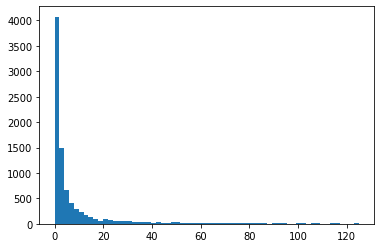

In [45]:
plt.hist(ejercicios_result, bins=int(T/2));